In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import healpy as hp
import pickle as pkl
import os

import GCRCatalogs
from GCRCatalogs import GCRQuery
from GCRCatalogs.helpers.tract_catalogs import tract_filter
GCRCatalogs.set_root_dir("/data/scratch/dc2_nfs/")

We specify the path at which we'll save the pkl file:

In [2]:
file_name = "dc2_lensing_catalog.pkl"
file_path = os.path.join("/data", "scratch", "dc2local", file_name)
file_already_populated = os.path.isfile(file_path)

---

### Object-with-truth–match

We load in the object-with-truth-match catalog and list all available quantities:

In [3]:
object_truth_cat = GCRCatalogs.load_catalog('desc_dc2_run2.2i_dr6_object_with_truth_match')

In [4]:
object_truth_cat.list_all_quantities()

['mag_i_cModel',
 'psFluxErr_r',
 'magerr_g_cModel',
 'IxxPSF_pixel_i',
 'mag_u',
 'xy_flag',
 'flux_y_truth',
 'Iyy_pixel_z',
 'cosmodc2_hp_truth',
 'match_sep',
 'IxxPSF_pixel_u',
 'IyyPSF_pixel_i',
 'psFlux_r',
 'mag_i_truth',
 'cModelFluxErr_i',
 'is_good_match',
 'Ixy_pixel_r',
 'mag_z_truth',
 'truth_type',
 'av_truth',
 'cModelFlux_g',
 'IxyPSF_pixel',
 'cModelFlux_i',
 'psNdata',
 'mag_r_truth',
 'flux_r_truth',
 'psf_fwhm_i',
 'IyyPSF_pixel_y',
 'I_flag_g',
 'rv_truth',
 'IxxPSF_pixel_z',
 'snr_i_cModel',
 'psFlux_y',
 'psFlux_flag_g',
 'magerr_i',
 'mag_y_cModel',
 'host_galaxy_truth',
 'patch_truth',
 'flux_z_truth',
 'I_flag_i',
 'psFluxErr_i',
 'psf_fwhm_y',
 'Iyy_pixel_u',
 'is_unique_truth_entry',
 'magerr_z',
 'flux_i_truth',
 'psFlux_flag_u',
 'mag_i',
 'IxxPSF_pixel_g',
 'Ixy_pixel_i',
 'mag_g_cModel',
 'psf_fwhm_g',
 'mag_g',
 'magerr_i_cModel',
 'psFlux_flag_i',
 'cModelFluxErr_r',
 'Ixx_pixel_i',
 'magerr_r',
 'Ixy_pixel',
 'flux_g_truth',
 'cModelFlux_z',
 'IyyPSF

And we fetch the variables we want. Note that we only need objects from tracts 3828 and 3829, as those are the only two tracts for which we have images.

In [5]:
object_truth_df = object_truth_cat.get_quantities(
    quantities = ["cosmodc2_id_truth", "id_truth", "objectId", "match_objectId",
                  "truth_type", "ra_truth", "dec_truth", "redshift_truth",
                  "flux_u_truth", "flux_g_truth", "flux_r_truth", "flux_i_truth", "flux_z_truth", "flux_y_truth",
                  "mag_u_truth", "mag_g_truth", "mag_r_truth", "mag_i_truth", "mag_z_truth", "mag_y_truth",
                  "Ixx_pixel", "Iyy_pixel", "Ixy_pixel",
                  "IxxPSF_pixel_u", "IxxPSF_pixel_g", "IxxPSF_pixel_r", "IxxPSF_pixel_i", "IxxPSF_pixel_z", "IxxPSF_pixel_y", 
                  "IyyPSF_pixel_u", "IyyPSF_pixel_g", "IyyPSF_pixel_r", "IyyPSF_pixel_i", "IyyPSF_pixel_z", "IyyPSF_pixel_y",
                  "IxyPSF_pixel_u", "IxyPSF_pixel_g", "IxyPSF_pixel_r", "IxyPSF_pixel_i", "IxyPSF_pixel_z", "IxyPSF_pixel_y",
                  "psf_fwhm_u", "psf_fwhm_g", "psf_fwhm_r", "psf_fwhm_i", "psf_fwhm_z", "psf_fwhm_y"],
    native_filters = [tract_filter([3828, 3829])]
)

object_truth_df = pd.DataFrame(object_truth_df)

We create an ra/dec filter that we'll apply to CosmoDC2, as well as an equivalent (but faster) healpix filter:

In [6]:
max_ra = np.nanmax(object_truth_df['ra_truth'])
min_ra = np.nanmin(object_truth_df['ra_truth'])
max_dec = np.nanmax(object_truth_df['dec_truth'])
min_dec = np.nanmin(object_truth_df['dec_truth'])
ra_dec_filters = [f'ra >= {min_ra}', f'ra <= {max_ra}', f'dec >= {min_dec}', f'dec <= {max_dec}']

In [7]:
vertices = hp.ang2vec(np.array([min_ra, max_ra, max_ra, min_ra]),
                      np.array([min_dec, min_dec, max_dec, max_dec]), lonlat=True)
ipix = hp.query_polygon(32, vertices, inclusive=True)
healpix_filter = GCRQuery((lambda h: np.isin(h, ipix, True), "healpix_pixel"))

We see that there are around 2.2 million objects in the object-truth table:

In [8]:
object_truth_df.shape

(2231901, 47)

But a small portion of these objects are stars or supernovae rather than galaxies, so we filter them out:

In [9]:
object_truth_df = object_truth_df[object_truth_df['truth_type'] == 1]

In [10]:
object_truth_df.shape

(2183536, 47)

Here are the different ID variables in the object-truth table:

In [11]:
object_truth_df[['cosmodc2_id_truth', 'id_truth', 'objectId', 'match_objectId']]

,cosmodc2_id_truth,id_truth,objectId,match_objectId
0,7816513885,7816513885,16835722044507628,16835722044507628
1,7812675090,7812675090,16835722044507640,16835722044507640
2,7814647934,7814647934,16835722044507645,16835722044507645
3,7814197393,7814197393,16835722044507650,16835722044507650
4,7813507782,7813507782,16835722044507655,16835722044507655
...,...,...,...,...
2231896,6879076188,6879076188,16840970494587085,16840970494587085
2231897,6887535927,6887535927,16840970494587086,16840970494587086
2231898,6894253191,6894253191,16840970494587087,16840970494587087
2231899,6880581337,6880581337,16840970494587088,16840970494587088


We see that `id` and `cosmodc2_id` are equivalent, at least for galaxies:

In [12]:
(object_truth_df['cosmodc2_id_truth'] == object_truth_df['id_truth']).mean()

1.0

And same goes for `objectId` and `match_objectId`:

In [13]:
(object_truth_df['objectId'] == object_truth_df['match_objectId']).mean()

1.0

Here's the distribution of magnitude in each band:

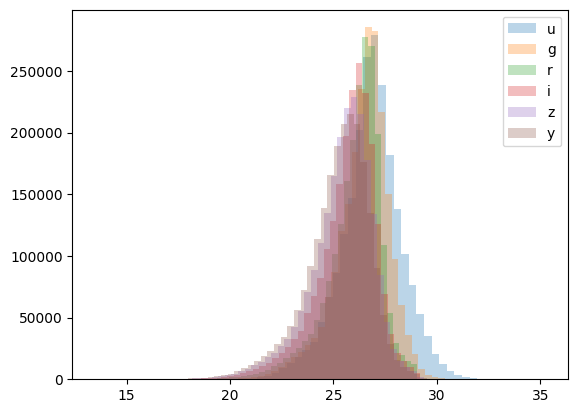

In [14]:
_ = plt.hist(object_truth_df['mag_u_truth'], bins = 50, alpha = 0.3, label = 'u')
_ = plt.hist(object_truth_df['mag_g_truth'], bins = 50, alpha = 0.3, label = 'g')
_ = plt.hist(object_truth_df['mag_r_truth'], bins = 50, alpha = 0.3, label = 'r')
_ = plt.hist(object_truth_df['mag_i_truth'], bins = 50, alpha = 0.3, label = 'i')
_ = plt.hist(object_truth_df['mag_z_truth'], bins = 50, alpha = 0.3, label = 'z')
_ = plt.hist(object_truth_df['mag_y_truth'], bins = 50, alpha = 0.3, label = 'y')
_ = plt.legend()

And here's the distribution of redshift:

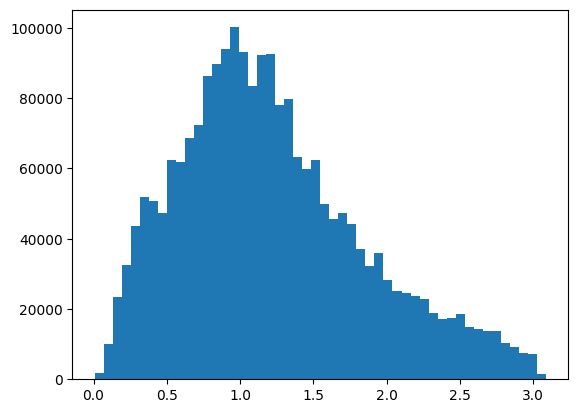

In [15]:
_ = plt.hist(object_truth_df['redshift_truth'], bins = 50)

---

### CosmoDC2

Next, we load in CosmoDC2 and list all available quantities:

In [16]:
config_overwrite = dict(
    catalog_root_dir='/data/scratch/dc2_nfs/cosmoDC2'
)

cosmo_cat = GCRCatalogs.load_catalog('desc_cosmodc2', config_overwrite)

In [17]:
cosmo_cat.list_all_quantities()

['sed_2407_591_disk_no_host_extinction',
 'mag_true_i',
 'sed_2998_186_no_host_extinction',
 'mag_true_g_lsst_no_host_extinction',
 'mag_true_g',
 'sed_1246_306_no_host_extinction',
 'Mag_true_i_lsst_z0_no_host_extinction',
 'sed_15143_2259',
 'sed_17402_2596_disk_no_host_extinction',
 'mag_true_y_lsst',
 'ellipticity_2_true',
 'mag_true_u_lsst',
 'sed_11467_1710_disk_no_host_extinction',
 'sed_3381_209_disk_no_host_extinction',
 'sed_1000_246_bulge',
 'halo_mass',
 'mag_u_lsst',
 'sed_6548_406_bulge',
 'mag_true_u_sdss_no_host_extinction',
 'sed_4848_300',
 'sed_7385_458_disk_no_host_extinction',
 'mag_g_sdss_no_host_extinction',
 'sed_3381_209_disk',
 'redshift',
 'sed_6954_431_bulge',
 'mag_true_i_sdss',
 'sed_5467_339_bulge_no_host_extinction',
 'sed_8329_517_no_host_extinction',
 'convergence',
 'sed_3381_209_no_host_extinction',
 'sed_3590_222_bulge',
 'shear_1',
 'mag_z_sdss',
 'Mag_true_Y_lsst_z0',
 'sed_17402_2596',
 'mag_true_z_sdss_no_host_extinction',
 'sed_11467_1710_bulge

And we fetch the variables we want.

Some notes:
- We only pull objects in the ra/dec region from the object-with-truth-match table, using the filters defined above.
- ellipticity_1_true and ellipticity_2_true are the unlensed ellipticities. Ideally we'd want the lensed versions ellipticity_1 and ellipticity_2, which are listed [here](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md) but are not available (see the above list). There's also ellipticity_1_true_dc2 and ellipticity_2_true_dc2, but those are deprecated.

In [18]:
cosmo_df = cosmo_cat.get_quantities(
    quantities = ["galaxy_id", "ra", "dec",
                  "ellipticity_1_true", "ellipticity_2_true",
                  "shear_1", "shear_2", "convergence"],
    filters = ra_dec_filters,
    native_filters = healpix_filter
)
cosmo_df = pd.DataFrame(cosmo_df)

We see that there are around 19.8 million galaxies in CosmoDC2:

In [19]:
cosmo_df.shape

(19760548, 8)

Here's the ID variable in CosmoDC2. It has the same format as `cosmodc2_id_truth` in the object-with-truth-match table:

In [20]:
cosmo_df['galaxy_id']

0           6812500143
1           6812500203
2           6812500261
3           6812500406
4           6812500408
               ...    
19760543    7895880381
19760544    7895880382
19760545    8763356635
19760546    8763707556
19760547    8764722134
Name: galaxy_id, Length: 19760548, dtype: int64

---

### Merge `object_truth_df` and `cosmo_df`

Now we merge the object-with-truth-match table with CosmoDC2 using the galaxies' CosmoDC2 IDs (`galaxy_id` in `cosmo_df` and `cosmodc2_id_truth` in `object_truth_df`).

In [21]:
merge_df = object_truth_df.merge(
    cosmo_df, 
    left_on = "cosmodc2_id_truth",
    right_on = "galaxy_id", 
    how = "left" 
)

As expected, the new data frame has the same number of rows as `object_truth_df`:

In [22]:
merge_df.shape

(2183536, 55)

But we find that there are around 300,000 galaxies in `object_truth_df` that are not in `cosmo_df`:

In [23]:
print(merge_df['galaxy_id'].isna().sum())
print(merge_df['galaxy_id'].isna().mean())

301020
0.13785895904624426


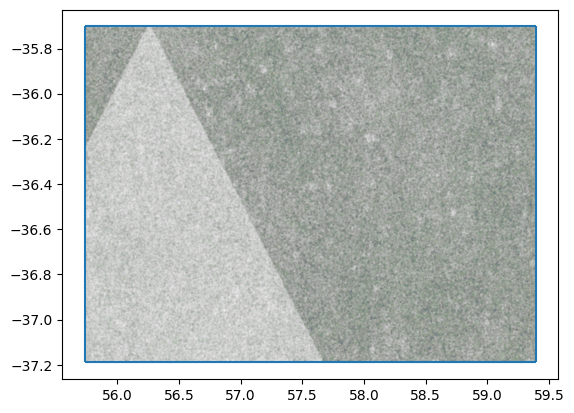

In [24]:
_ = plt.scatter(merge_df['ra_truth'][~merge_df['galaxy_id'].isna()],
                merge_df['dec_truth'][~merge_df['galaxy_id'].isna()],
                c = merge_df['redshift_truth'][~merge_df['galaxy_id'].isna()], alpha = 0.005, s = 1)
_ = plt.vlines(x = [min_ra, max_ra], ymin = max_dec, ymax = min_dec)
_ = plt.hlines(y = [min_dec, max_dec], xmin = min_ra, xmax = max_ra)

It appears that this small number of galaxies is missing from a portion of the sky in CosmoDC2. We've confirmed that this is an inherent problem in CosmoDC2 itself and is not related to our merging strategy. The other BLISS projects that work with DC2 have encountered the same problem.

We filter these galaxies out since they do not have shear, convergence, or ellipticity (and thus are not useful for our purposes):

In [25]:
merge_df = merge_df[~merge_df['galaxy_id'].isna()]

We confirm that the distribution of per-band magnitude and the distribution of redshift are essentially the same as before:

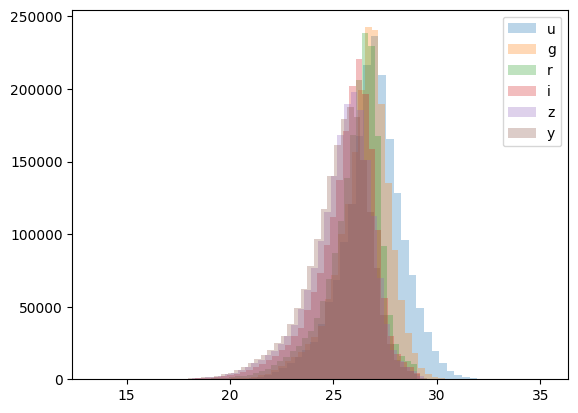

In [26]:
_ = plt.hist(merge_df['mag_u_truth'], bins = 50, alpha = 0.3, label = 'u')
_ = plt.hist(merge_df['mag_g_truth'], bins = 50, alpha = 0.3, label = 'g')
_ = plt.hist(merge_df['mag_r_truth'], bins = 50, alpha = 0.3, label = 'r')
_ = plt.hist(merge_df['mag_i_truth'], bins = 50, alpha = 0.3, label = 'i')
_ = plt.hist(merge_df['mag_z_truth'], bins = 50, alpha = 0.3, label = 'z')
_ = plt.hist(merge_df['mag_y_truth'], bins = 50, alpha = 0.3, label = 'y')
_ = plt.legend()

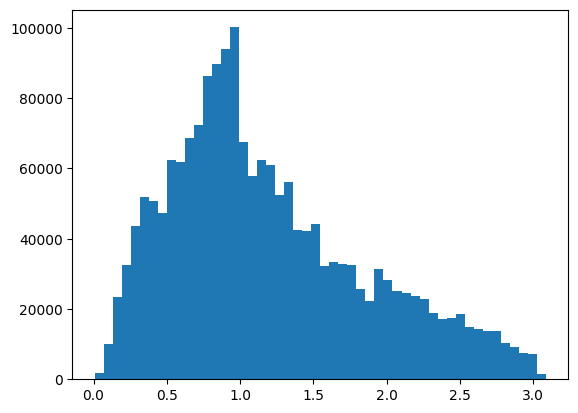

In [27]:
_ = plt.hist(merge_df['redshift_truth'], bins = 50)

And now we can examine shear and convergence, which were initially in `cosmo_df`:

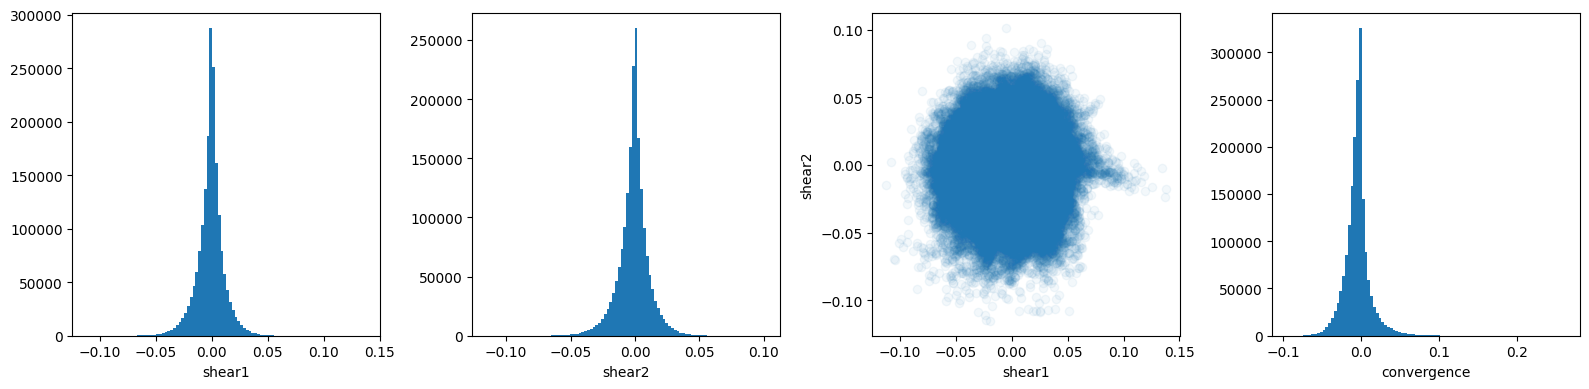

In [28]:
fig, ax = plt.subplots(1, 4, figsize = (16,4))
_ = ax[0].hist(merge_df['shear_1'], bins = 100)
_ = ax[0].set_xlabel('shear1')
_ = ax[1].hist(merge_df['shear_2'], bins = 100)
_ = ax[1].set_xlabel('shear2')
_ = ax[2].scatter(merge_df['shear_1'], merge_df['shear_2'], alpha = 0.05)
_ = ax[2].set_xlabel('shear1')
_ = ax[2].set_ylabel('shear2')
_ = ax[3].hist(merge_df['convergence'], bins = 100)
_ = ax[3].set_xlabel('convergence')
fig.tight_layout()

We remove `ra_truth` and `dec_truth` since they're the same as `ra` and `dec`, respectively:

In [29]:
merge_df.drop(columns = ['ra_truth', 'dec_truth'], inplace = True)

And finally, we remove the `_truth` suffix from the mag, flux, and redshift variables:

In [30]:
merge_df.rename(columns = {
    "redshift_truth": "redshift",
    "flux_u_truth": "flux_u",
    "flux_g_truth": "flux_g",
    "flux_r_truth": "flux_r",
    "flux_i_truth": "flux_i",
    "flux_z_truth": "flux_z",
    "flux_y_truth": "flux_y",
    "mag_u_truth": "mag_u",
    "mag_g_truth": "mag_g",
    "mag_r_truth": "mag_r",
    "mag_i_truth": "mag_i",
    "mag_z_truth": "mag_z",
    "mag_y_truth": "mag_y",
}, inplace = True)

---

Finally, we save `merge_df` to `file_path`:

In [31]:
with open(file_path, "wb") as f:
    pkl.dump(merge_df, f)